- Pradeep Gahlawat
- 10524011
- Driver drowsiness detection system
- file 3/4 (Baseline models: SVM and MLP)

In [1]:
# used libraries and functions.
import warnings
import pandas as pd
import seaborn as sns
import glob
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

## Data Collection and Validation

In [2]:
# Collect normalised data for alert class 
df_alert = pd.read_csv('normalised_alert.csv', index_col=None, header=0)
# Describe features distributions
df_alert.describe()

,EAR,MAR,CIR,MOE,PITCH,ROLL,YAW,Subject,Label
count,6480.000000,6480.000000,6480.000000,6480.000000,6480.000000,6480.000000,6480.000000,6480.000000,6480.0
mean,-1.114148,0.348405,-1.016265,2.426901,-11.350358,-0.292324,1.583531,32.333333,0.0
std,9.874432,6.253053,6.496300,9.827736,5.396723,3.149570,9.416338,16.963140,0.0
min,-264.817526,-208.721176,-75.838571,-19.431376,-84.809831,-21.120917,-35.120723,2.000000,0.0
25%,-2.254613,-1.223197,-1.273845,-0.891324,-14.782821,-1.862237,-5.090220,17.000000,0.0
50%,0.082433,0.174717,0.145718,-0.023899,-10.892913,-0.387182,1.248965,34.000000,0.0
75%,1.107218,1.871034,1.155580,2.606994,-7.575725,1.295315,7.879274,50.000000,0.0
max,103.888692,184.692094,15.272632,235.709706,34.842207,25.532045,33.427154,59.000000,0.0


In [3]:
# print first five rows of the dataframe and get the total number of subjects.
Total_subjects = len(df_alert['Subject'].value_counts())
print('{0} Subjects'.format(Total_subjects))
df_alert.head()

27 Subjects


,EAR,MAR,CIR,MOE,PITCH,ROLL,YAW,Subject,Label
0,-0.550721,-1.023081,-0.524465,-0.980054,-9.285217,3.778707,-14.842664,2,0
1,1.154297,0.047883,1.153132,-0.038766,-12.513995,3.902266,-12.958471,2,0
2,-0.603576,0.975199,-0.628667,1.018819,-11.132252,4.199708,-13.745930,2,0
3,23.810252,0.465684,0.173800,-1.259177,-9.079930,3.509181,-13.497998,2,0
4,48.250473,1.182332,3.115115,-2.219004,-9.038324,3.384242,-13.386110,2,0


In [4]:
# Collect normalised data for drowsy class
df_drowsy = pd.read_csv('normalised_drowsy.csv', index_col=None, header= 0)
# Describe features distributions
df_drowsy.describe()

,EAR,MAR,CIR,MOE,PITCH,ROLL,YAW,Subject,Label
count,6480.000000,6480.000000,6480.000000,6480.000000,6480.000000,6480.000000,6480.000000,6480.000000,6480.0
mean,-7.099157,3.468018,-4.124292,10.009002,-8.138030,-0.047372,3.558490,32.333333,1.0
std,17.899604,10.827417,11.261823,19.511272,8.507008,4.639051,9.931154,16.963140,0.0
min,-315.664612,-41.875322,-77.077666,-21.952335,-85.246005,-26.270791,-64.260677,2.000000,1.0
25%,-7.259599,-1.001812,-3.680614,0.838760,-13.026784,-2.339298,-3.009269,17.000000,1.0
50%,-2.340936,2.065839,-1.453586,3.543817,-7.983333,0.103359,3.097460,34.000000,1.0
75%,-0.173233,6.236195,0.161230,9.563593,-2.169844,2.344953,8.871614,50.000000,1.0
max,70.978399,101.403600,32.682321,267.938715,36.700000,30.800000,41.070155,59.000000,1.0


In [5]:
# print first five rows of the dataframe and get the total number of subjects.
Total_subjects = len(df_drowsy['Subject'].value_counts())
print('{0} Subjects'.format(Total_subjects))
df_drowsy.head()

27 Subjects


,EAR,MAR,CIR,MOE,PITCH,ROLL,YAW,Subject,Label
0,-29.622914,5.120415,0.396596,7.798019,-16.188460,0.159043,-3.683589,2,1
1,-35.251043,4.235603,-0.206001,7.398498,-16.487110,1.110645,-6.274052,2,1
2,1.654082,5.287541,0.211370,5.130980,-17.017663,1.308164,-7.108814,2,1
3,14.047786,4.282553,1.069328,3.127476,-16.135447,1.050373,-6.417516,2,1
4,-106.122230,4.933330,-2.530253,16.437625,-15.150283,0.244006,-5.177332,2,1


### Spliting data into train and test sets.

In [8]:
# aggregate entire data based on subject number to randomly shuffle subjects
df = pd.concat([df_alert, df_drowsy], axis=0, join='inner', ignore_index=True)
groups = [df for _, df in df.groupby('Subject')]
random.shuffle(groups)
df = pd.concat(groups).reset_index(drop=True)

# Setting train and test index to split data into roughly 3:1 ratio for train and test respectively.
train_index = 9600
test_index = len(df)-train_index
df_train = df[:train_index]
df_test = df[-test_index:]

# print total number of subjects in both train and test data
Total_subjects = len(df_train['Subject'].value_counts())
print('Total subjects in train set: {0}'.format(Total_subjects))
Total_subjects = len(df_test['Subject'].value_counts())
print('Total subjects in test set: {0}'.format(Total_subjects))

Total subjects in train set: 20
Total subjects in test set: 7


In [10]:
# get features matrix and labels vector for both train and test data
X_train = df_train[['EAR', 'MAR', 'CIR', 'MOE', 'PITCH', 'ROLL', 'YAW']]
y_train = df_train['Label']
print(X_train.shape, y_train.shape)

X_test = df_test[['EAR', 'MAR', 'CIR', 'MOE', 'PITCH', 'ROLL', 'YAW']]
y_test = df_test["Label"]
print(X_test.shape, y_test.shape)

(9600, 7) (9600,)
(3360, 7) (3360,)


### Required functions for optimization and evaluation

In [11]:
# few functions to optimize and evaluate trained models.
# --best_parameters
# --average
# --roc_values
# --confusion_matrices
# --clf_report

def best_parameters(clf_grid, param1, param2):
    '''This function computes the train and cross-validation score for pair of hyperparameters.'''
    
    train_auc = clf_grid.cv_results_['mean_train_score']
    cv_auc = clf_grid.cv_results_['mean_test_score']
    
    # Create a dataframe to be used for heat-map
    hyperparameters = clf_grid.cv_results_["params"]
    df = pd.DataFrame(hyperparameters)
    df['mean_test_score'] = cv_auc
    df['mean_train_score'] = train_auc

    # Heat-map for train and cv auc values.
    pivot_train = df.pivot(index = param1, columns = param2, values = 'mean_train_score')
    pivot_cv = df.pivot(index = param1, columns = param2, values = 'mean_test_score')
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,6))
    ax1.set_title('Accuracy on Train Data ')
    ax2.set_title('Accuracy on CV Data')
    sns.heatmap(pivot_train, annot=True, ax=ax1)
    sns.heatmap(pivot_cv, annot=True, ax=ax2)
    return plt.show()

def average(y_pred):
    '''This function computes sequential predition i.e. average of three sequential predctions'''
    
    for i in range(len(y_pred)):
        if i % 60 == 0 or (i+1) % 60 == 0:
            pass
        else:
            average = float(y_pred[i-1] +  y_pred[i] + y_pred[i+1])/3
            if average >= 0.5:
                y_pred[i] = 1
            else:
                y_pred[i] = 0
    return y_pred  

def roc_values(clf):
    '''This function plots the ROC curve for both train and test data with correponding auc values'''
    
    y_test_predicted_prob = clf.predict_proba(X_test)[:,1]
    y_test_predicted_prob = average(y_test_predicted_prob)
    y_train_predicted_prob = clf.predict_proba(X_train)[:,1]
    y_train_predicted_prob = average(y_train_predicted_prob)

    # ROC and AUC value on train data
    plt.figure(figsize=(7,6))
    fpr, tpr, threshold = roc_curve(y_train, y_train_predicted_prob)
    roc_auc_train = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, 'r', label = 'Train AUC = %0.2f' % roc_auc_train)
    plt.legend(loc = 'lower right')
    # ROC and AUC value on test data
    fpr, tpr, threshold = roc_curve(y_test, y_test_predicted_prob)
    roc_auc_test = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, 'g', label = 'Test AUC = %0.2f' % roc_auc_test)
    plt.legend(loc = 'lower right')

    plt.plot([0, 1], [0, 1],'b--')
    plt.title('ROC for Train and CV Data', size = 15)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    return plt.show()

def confusion_matrices(clf):
    '''This function plots the confusion metrices for both train and test data'''
    
    y_test_predicted = clf.predict(X_test)
    y_test_predicted = average(y_test_predicted)
    y_train_predicted = clf.predict(X_train)
    y_train_predicted = average(y_train_predicted)
    
    # plot confusion matrix on train data
    fig = plt.figure(figsize=(12,5))
    ax1 = fig.add_subplot(121)
    ax1.title.set_text('Confusion matrix on Train data')
    conf_matrix_train = confusion_matrix(y_train, y_train_predicted)
    class_label = ['negative', 'positive']
    df_conf_matrix = pd.DataFrame(conf_matrix_train, index=class_label, columns=class_label)
    sb.heatmap(df_conf_matrix, annot=True, fmt='d')
    # plot confusion matrix on test data
    ax2 = fig.add_subplot(122)
    ax2.title.set_text('Confusion matrix on Test data')
    conf_matrix_test = confusion_matrix(y_test, y_test_predicted)
    df_conf_matrix = pd.DataFrame(conf_matrix_test, index=class_label, columns=class_label)
    sb.heatmap(df_conf_matrix, annot=True, fmt='d')
    return plt.show() 

def clf_report(clf):
    ''' This function computes accuracy, f1_score, recall and precision on test data'''
    
    y_test_predicted = clf.predict(X_test)
    y_test_predicted = average(y_test_predicted)
       
    # Model Accuracy: how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_test_predicted))
    # Model Precision: what percentage of positive tuples are labeled as such?
    print("Precision:",metrics.precision_score(y_test, y_test_predicted))
    # Model Recall: what percentage of positive tuples are labelled as such?
    print("Recall:",metrics.recall_score(y_test, y_test_predicted))
    # Model Recall: what percentage of positive tuples are labelled as such?
    print("F1_score:",metrics.f1_score(y_test, y_test_predicted))

## Support Vector Machines

### Training

In [12]:
# using GridsearCV and Stratified K-fold cross validation for hyperparameter tuning
param_grid = {'C': [.1, 1, 25, 50],  
              'gamma': [.001, .01, .1, 1]}  

classifier = SVC(kernel = 'rbf', probability=True)   ## initiating SVC classifier with rbf kernel

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
clf_grid1 = GridSearchCV(classifier, param_grid=param_grid, cv = cv,
                        n_jobs=-1, scoring='accuracy', refit=True, return_train_score=True)

%time clf_grid1.fit(X_train, y_train)
print("Best Parameters :\n",clf_grid1.best_estimator_)

Wall time: 14min 7s
Best Parameters :
 SVC(C=50, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


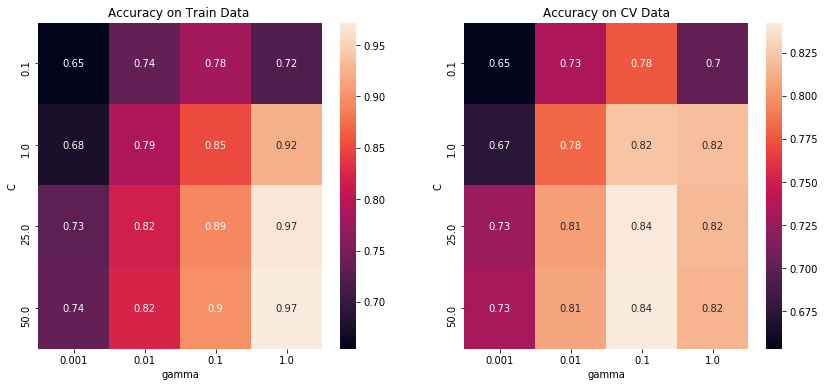

In [13]:
# visualize the score of train and validation sets for different combinations of the parameters
best_parameters(clf_grid1, 'C', 'gamma')

In [13]:
# Fit Sklearn implemented SVC Classifier with optimal value.
clf1 = SVC(C=50, gamma=.1, kernel='rbf', probability=True)
# fit the MLP instance with train data and labels
%time clf1.fit(X_train, y_train)

Wall time: 21 s


SVC(C=50, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

### Evaluation

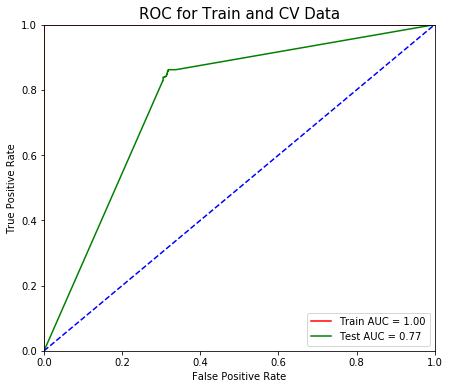

In [14]:
# compute ROC curve and AUC value for both train and test data
roc_values(clf1)

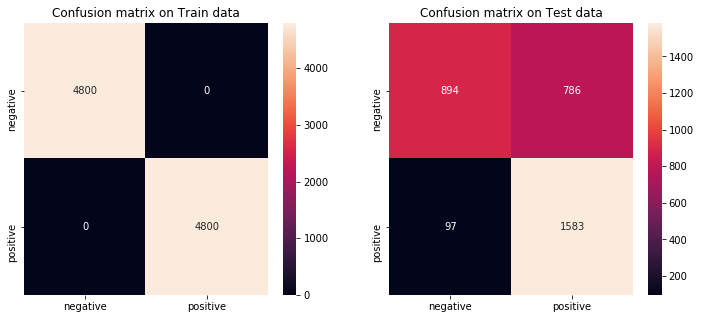

In [15]:
# Visualize TP,TN,FP,FN rates for both train and test data
confusion_matrices(clf1)

In [16]:
# get accuracy, precision, recall and f1_score of the model on test data
clf_report(clf1)

Accuracy: 0.737202380952381
Precision: 0.6682144364710848
Recall: 0.9422619047619047
F1_score: 0.7819214620894047


## Multi-Layer Perceptron

### Training

In [17]:
# using GridsearCV and Stratified K-fold cross validation for hyperparameter tuning

param_grid = {'hidden_layer_sizes': [1, 10, 100, 150],  
              'activation': ['logistic','tanh','relu']}
#              'solver': ['sgd','adam','lbfgs']} 

classifier = MLPClassifier(max_iter = 1000)  ## initiating multi layer perceptron classifier

clf_grid2 = GridSearchCV( classifier, param_grid=param_grid, cv = cv,
                        n_jobs=-1, scoring='accuracy', refit=True, return_train_score=True)

%time clf_grid2.fit(X_train, y_train)
print("Best Parameters :\n",clf_grid2.best_estimator_)

Wall time: 16min 3s
Best Parameters :
 MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=150, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


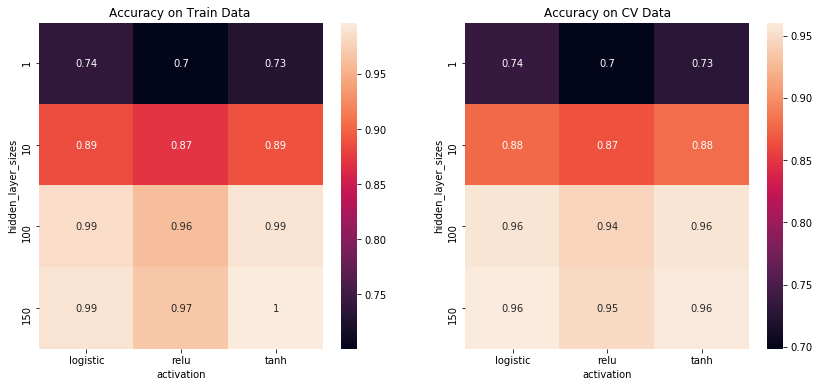

In [18]:
# visualize the score of train and validation sets for different combinations of the parameters
best_parameters(clf_grid2, 'hidden_layer_sizes', 'activation')

In [19]:
# Fit Sklearn implemented MLP Classifier with optimal parameters.
clf2 = MLPClassifier(hidden_layer_sizes = 150, activation = 'tanh', solver = 'sgd' )
# fit the MLP instance with train data and labels
%time clf2.fit(X_train, y_train)

Wall time: 29.9 s


C:\Users\Pradeep\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=150, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

### Evaluation

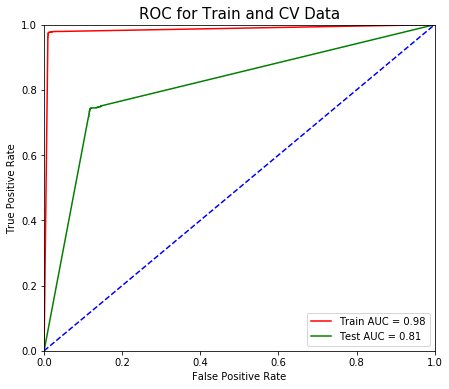

In [20]:
# compute ROC curve and AUC value for both train and test data
roc_values(clf2)

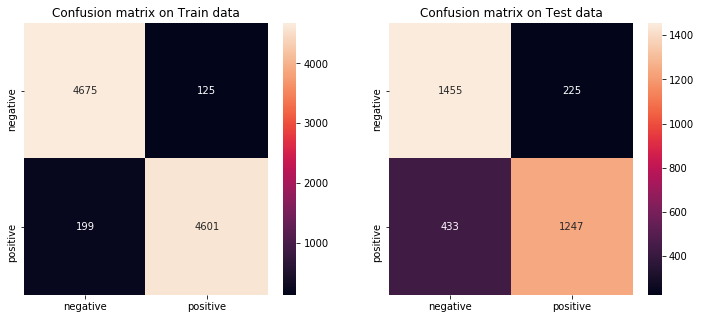

In [21]:
# Visualize TP,TN,FP,FN rates for both train and test data
confusion_matrices(clf2)

In [22]:
# get accuracy, precision, recall and f1_score of the model on test data
clf_report(clf2)

Accuracy: 0.8041666666666667
Precision: 0.8471467391304348
Recall: 0.7422619047619048
F1_score: 0.791243654822335
